<a href="https://colab.research.google.com/github/Valentina-Gol/math_packages_leti/blob/main/lab1/math_package_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №1

**Цель работы**  
Изучить возможности библиотек Python для решения задач цифровой
обработки сигналов.

**Задачи лабораторной работы**
1.  Освоить Jupyter Notebook.  
2.  Выполнить загрузку аудио сигнала и построить огибающую (график).  
3.  Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный
сигнал.  
4.  Детектор сигнал/шум. Получить сигнал после детектирования.  
5.  Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6.  Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

In [1]:
from google.colab import drive
drive.mount('/content/drive/') # монтируем папку своего гугл диска

Mounted at /content/drive/


In [ ]:
from scipy.io import  wavfile
import scipy.io
# загружаем исходный звуковой сигнал
sample_rate, data = wavfile.read('/content/drive/MyDrive/Colab_Notebooks/03-01-05-01-01-02-03_A3.wav')

## Загрузка аудио сигнала и построение огибающей кривой

Имеется сигнал $x(i), i = 0,1,...,N-1$. Хотим построить огибающую $y(j), j = 0,1,...,n-1$. Пусть $m = \left[ \frac{N} n \right] $ - число точек в интервале усреднения. Тогда $y(i) = \frac{1} m \displaystyle\sum^{mj+m-1}_{k=mj} |x(k)| $ 

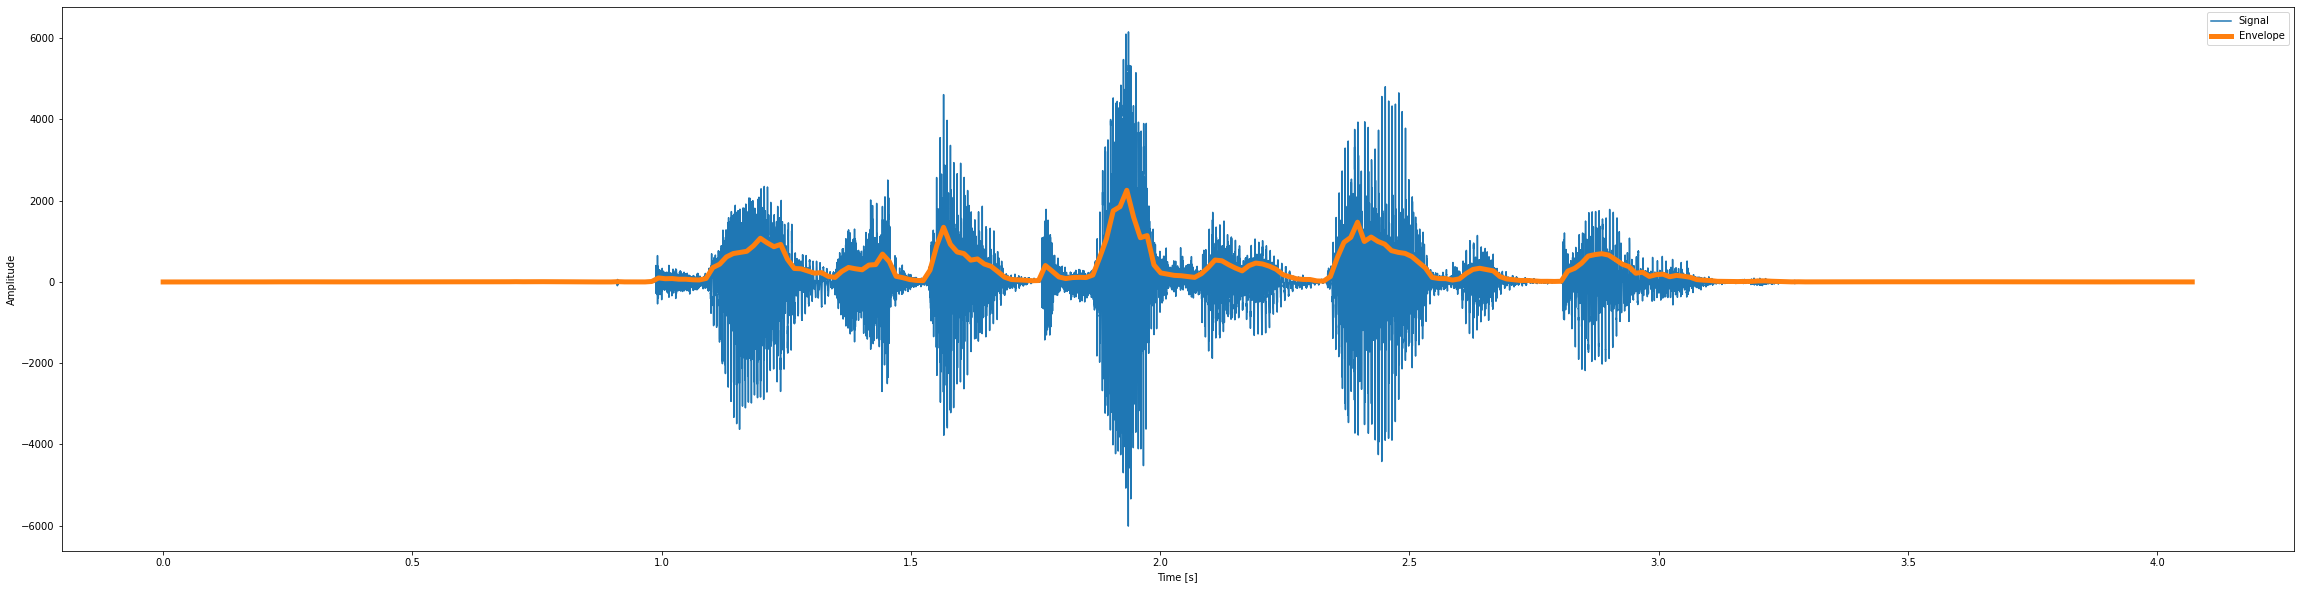

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# устанавливаем количество точек для построения кривой
num_dots = 300
length_signal = data.shape[0] / sample_rate
time = np.linspace(0, length_signal, data.shape[0])
m = int(data.shape[0] / num_dots)
curve = np.linspace(0, length_signal, num_dots)
curve_values = []
# считаем значения для кривой
for j in range(num_dots):
  sum = 0
  for k in range(m * j, m * j + m):
    sum += abs(data[k])
  curve_values.append(sum / m)
  
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(time, data, label="Signal")
plt.plot(curve, curve_values, label="Envelope", linewidth=5)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Фильтрация сигнала

Был выбран фильтр нижних частот.  
Пусть $F_{d}$ - частота дискретизации, частота среза - $F_{s}$, порядок фильтра - $m$. Тогда вычисляем $wn = 2\frac{F_{s}} {F_{d}}$

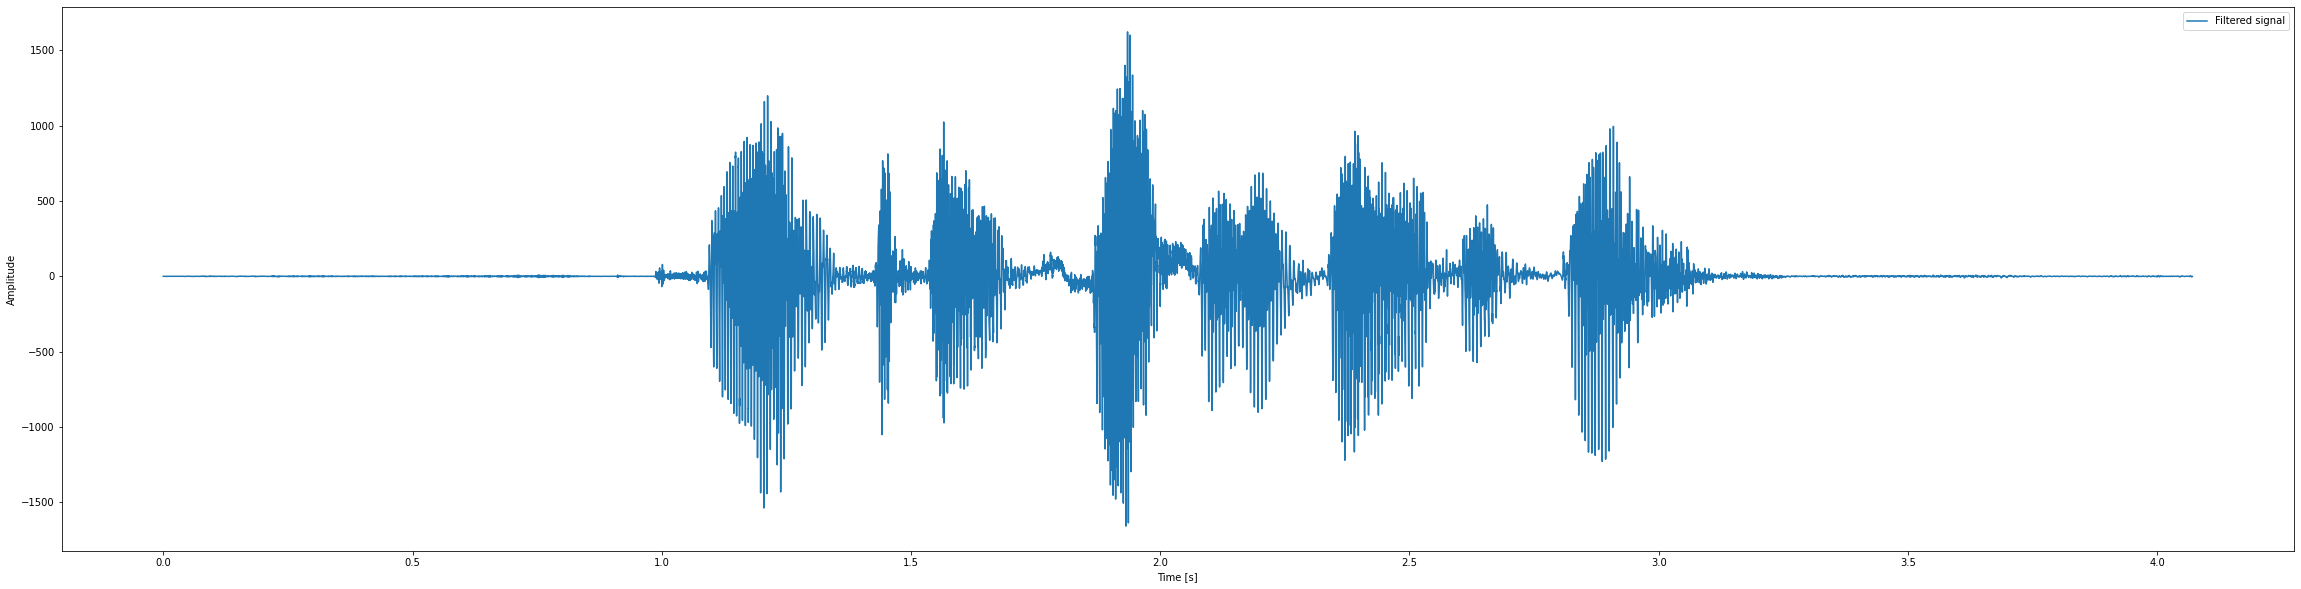

In [4]:
from scipy import signal
# выбираем значения частоты среза и порядок фильтра
Fs = 500
m = 1
wn = 2 * Fs / sample_rate
# применяем фильтр нижних частот
b, a = signal.butter(m, wn, 'lowpass')
filtered_data = signal.filtfilt(b, a, data)

f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(time, filtered_data, label="Filtered signal")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Детектор сигнал/шум

Определяем среднее сигнала по амплитуде (без учета знака): $mid = \frac{1} N \displaystyle\sum^{N-1}_{k=0}|x(k)|$ 

Определяем порог детектора — $Th = \alpha ∗ mid$, где $0 < \alpha < 1$ подбирается экспериментально.
Задаем величину ”провала”(в отсчетах) — $k$. Обозначим $y(i)$ — сигнал после
детектирования.  

$\cdot$ Событие ”начало сигнала”. Если $x(i)$ в течении $k$ отсчетов превышает порог, $y(i) = x(i)$.  
$\cdot$ Событие ”окончание сигнала”. Если $x(i)$ в течении $k$ отсчетов меньше порога, $y(i) = 0$.

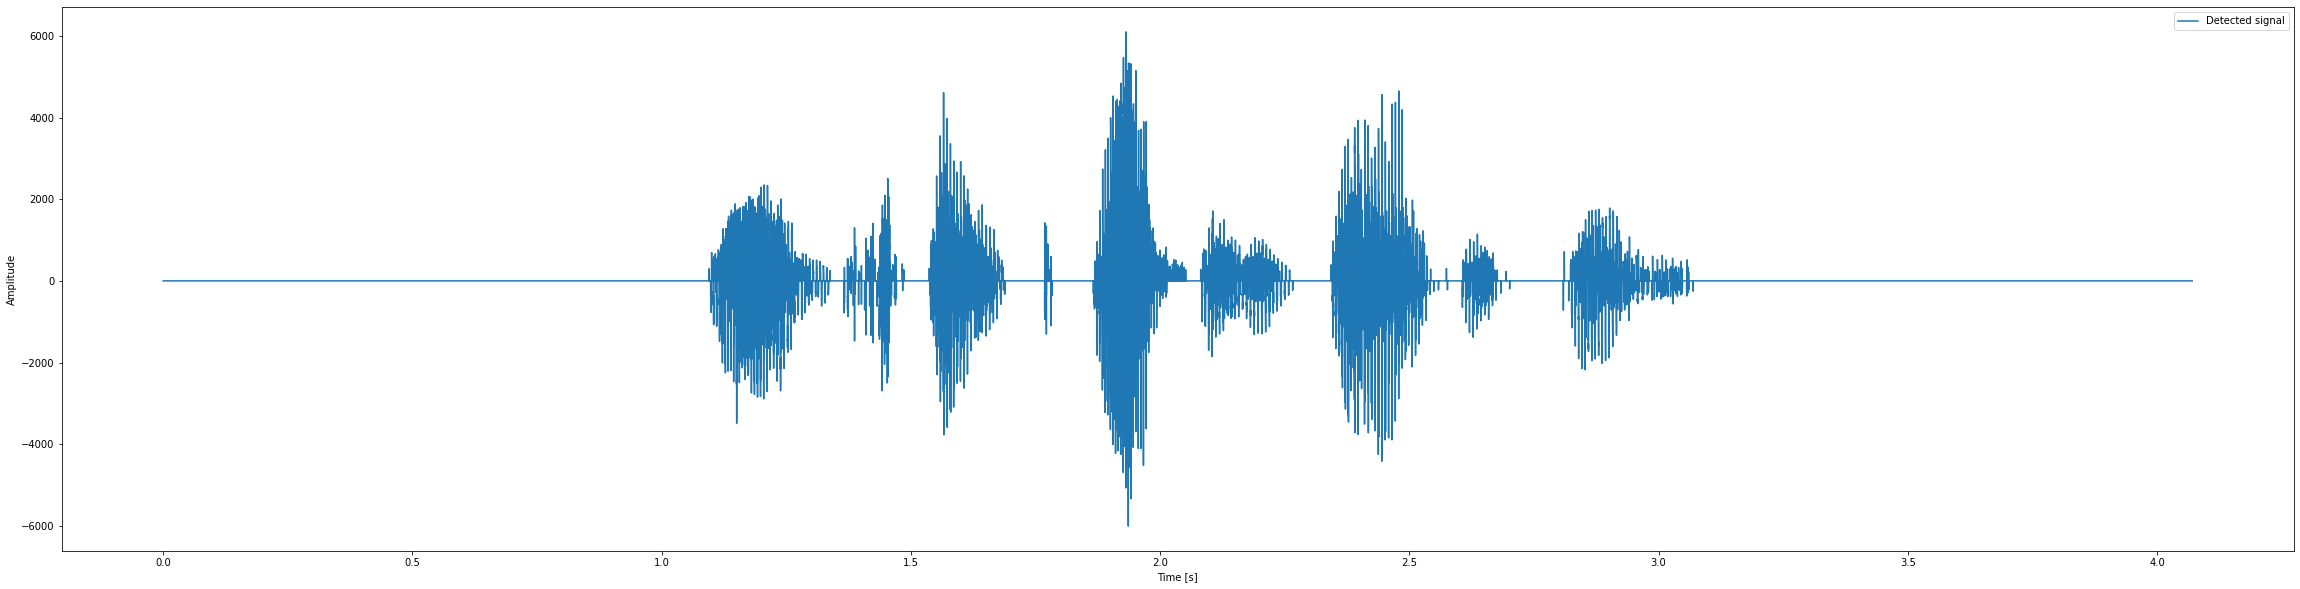

In [5]:
mid = 0
# определяем порог детектора
for k in range(data.shape[0]):
  mid += abs(data[k])
mid = mid / data.shape[0]
alpha = 0.9
Th = alpha * mid

k = 10
yi = np.zeros(data.shape[0])
is_signal = False
counter_signal = 0
counter_no_signal = 0
# детектируем события начала и окончания сигнала
for ind in range(data.shape[0]):
  if abs(data[ind]) > Th:
    counter_signal += 1
    counter_no_signal = 0
    if counter_signal >= k:
      is_signal = True
      yi[ind] = data[ind]
  else:
    counter_no_signal += 1
    counter_signal = 0
    if counter_no_signal >= k:
      is_signal = False

f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(time, yi, label="Detected signal")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Эффект ”Эхо”

Ревербератор реализован, как набор линий задержки. Число линий задержки $N_{L} > 8$.
Каждая линия задержки имеет свой весовой коэффициент (задается пользователем):
$\alpha_{1} > \alpha_{2} > \dots > \alpha_{N_{L}}$.  
$\cdot$ Перед добавлением к исходному сигналу, выход ревербератора фильтруется
ФНЧ-фильтром первого порядка.   
$\cdot$ Желаемое соотношение между ”сухим”и обработанным сигналом задается
коэффициентом применимости $\gamma$.  
$\cdot$ Ревербератор может работать в двух режимах: ручной и с использованием готовой
конфигурации (preset). Для ручного режима регулируется пользователем задается
максимальная задержка $D_1$ , а величины остальных определяются автоматически через
нее: $D_i = D_1 2 \frac{1-i} {N_L}, i = 2, \dots,N_L$.  
Для готовой конфигурации пользователь вручную задает последовательность $D_1 > D_2 > \dots > D_{N_L}$.

Введите режим ввода массива задержек(preset or manual) preset
Введите максимальную задержку D1 100000


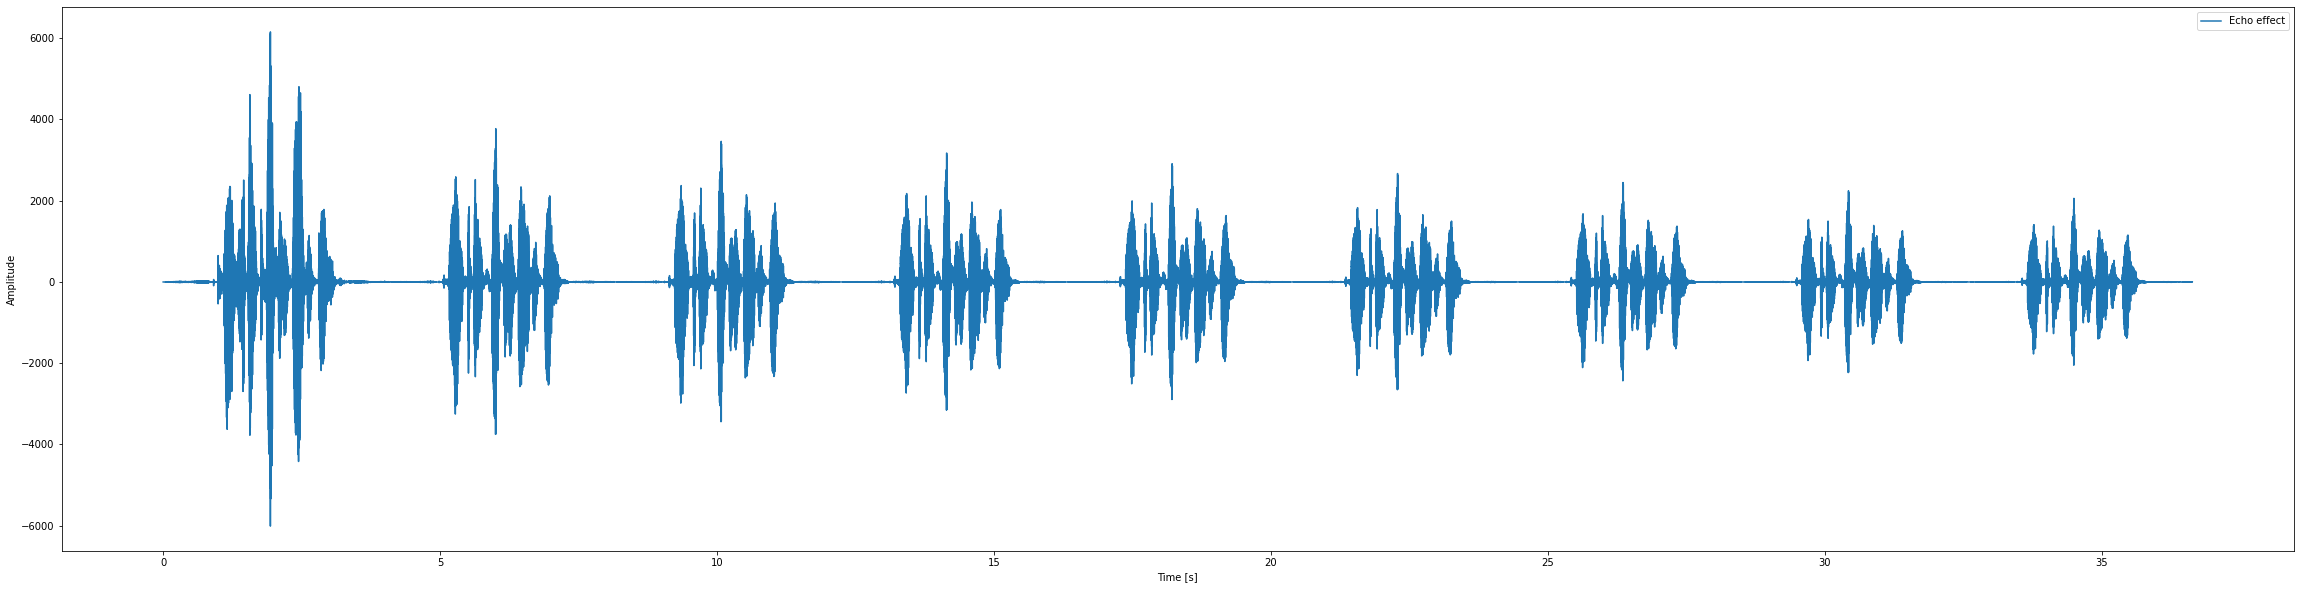

In [6]:
def input_delay() -> list:
  Darray = input("Введите 8 задержек через пробел(каждая строго меньше предыдущей)").split()
  Darray = [int(value) for value in Darray]
  for ind in range(len(Darray) - 1):
    if Darray[ind] <= Darray[ind + 1]:
      return [False, Darray]
  return [True, Darray]

resultArr = np.zeros(data.shape[0] * 9)
resultArr[0:data.shape[0]] = data
gamma = 0.9
arrayDi = []
# выбор режима и установка величины задержки
work_mode = input("Введите режим ввода массива задержек(preset or manual) ")
if work_mode == "preset":
  D1 = int(input("Введите максимальную задержку D1 "))
  arrayDi = [D1 * 2 ** ((1 - i) / 8) for i in range(2, 9)]
  arrayDi = np.insert(arrayDi, 0, D1)
elif work_mode == "manual":
  flag, arrayDi = input_delay()
  if not flag:
    raise Exception("Недопустимые значения величин задержек")
else:
  raise Exception("Недопустимый режим ввода задержек")    
addArr = np.zeros(data.shape[0] * 8)
for ind in range(len(arrayDi)):
  delay = arrayDi[ind]
  alphai = delay / sample_rate
  xi = data * alphai
  addArr[ind * data.shape[0] : (ind + 1) * data.shape[0]] = xi[:]
# выбираем значения частоты среза и порядок фильтра
Fs = 600
m = 1
wn = 2 * Fs / sample_rate
# применяем фильтр нижних частот
b, a = signal.butter(m, wn, 'lowpass')
filtered_data = signal.filtfilt(b, a, addArr)
addArr = filtered_data * gamma
resultArr[data.shape[0]:] = addArr 

f = plt.figure()
f.set_figwidth(40)
f.set_figheight(10)
plt.plot(np.linspace(0, length_signal * 9, data.shape[0] * 9), resultArr, label="Echo effect")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()


## Эффект ”Distortion”

Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i) i = 0,1, \dots,N − 1$. Пользователь задает порог — $Th$ и максимальное значение
сигнала $Max > Th$. Тогда $Y(i) = 
 \begin{cases} x(i), |x(i)| \leq Th, \\ Max * sign(x(i)), |x(i)| > Th
 \end{cases}
$

In [7]:
Th = int(input("Введите порог "))
Max = int(input("Введите максимальное значение сигнала "))

Введите порог 400
Введите максимальное значение сигнала 1000


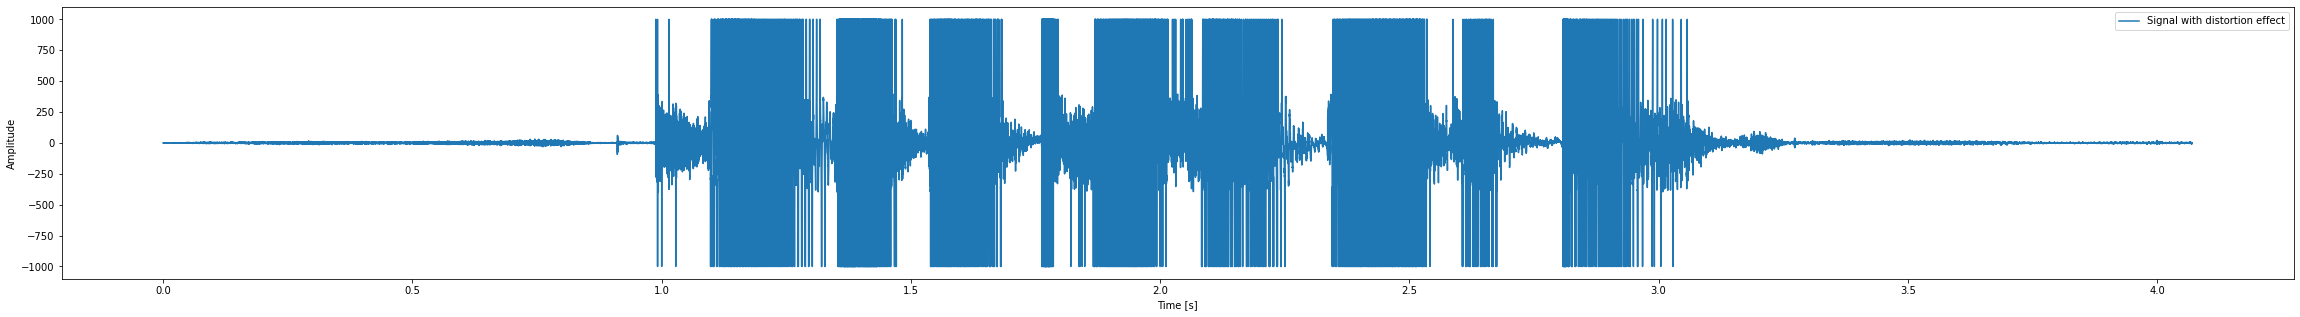

In [8]:
def sign(value) -> int:
  if value < 0:
    return -1
  elif value > 0:
    return 1
  return 0    

yi = np.zeros(data.shape[0])
# ограничиваем сигнал по амплитуде
for ind in range(data.shape[0]):
  if abs(data[ind]) < Th:
    yi[ind] = data[ind]
  else:
    yi[ind] = Max * sign(data[ind])
   
f = plt.figure()
f.set_figwidth(40)
f.set_figheight(5)
plt.plot(time, yi, label="Signal with distortion effect")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()    

### **Выводы по лабораторной работе**

Были получены навыки работы с Jupyter Notebook, а также с библиотеками языка python - matplotlib, numpy, scipy, были получены навыки обработки и визуализации звуковых сигналов

